## Predicting Win or Loss of League of Legend games in korean server using linear SVM

- Data used here can be colleced by follwing this code : https://github.com/jaewonalive/Data_Engineering/blob/master/pipeline_data_engineering(challenger).ipynb

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

## Data Loading

In [49]:
mydata = pd.read_csv('챌린저_마스터_그마데이터(13_KR).csv')

In [50]:
mydata = mydata[mydata['gameMode'] == 'CLASSIC']

drop_ls = ['gameId',
           'queueId',
           'platformId',
           'gameCreation',
           'mapId',
           'gameMode',
           'teamId_blue',
           'teamId_red',
        'seasonId',
        'gameVersion',
          'gameType',
          'teams',
          'participants',
           'participantIdentities',
           'bans_blue',
           'bans_red']
           
           
mydata.drop(columns=drop_ls, inplace=True)
print('Data shape :', mydata.shape)

Data shape : (19928, 206)


## Data Preprocessing

In [51]:
encoding = {'win_blue' : {'Win' : 1, 'Fail' : -1}}
mydata.replace(encoding, inplace=True)
mydata.dropna(inplace=True)

x = mydata[mydata.columns[~mydata.columns.isin(['win_blue'])]]
y = mydata[mydata.columns[mydata.columns.isin(['win_blue'])]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

min_max_scaler = MinMaxScaler()
fitted = min_max_scaler.fit(x_train)

output = min_max_scaler.transform(x_train)
x_test = min_max_scaler.transform(x_test)
x_train = pd.DataFrame(output, columns=x_train.columns, index=list(x_train.index.values))
output = x_train.join(y_train)

In [52]:
y_train.win_blue.value_counts()

 1    7017
-1    6932
Name: win_blue, dtype: int64

## EDA

In [53]:
pca = PCA(n_components=50)
pca_result = pca.fit_transform(x_train.values)

output['pca-one'] = pca_result[:,0]
output['pca-two'] = pca_result[:,1] 
output['pca-three'] = pca_result[:,2]


expl_var_ratio = pca.explained_variance_ratio_

print('Explained variation per principal component: {}'.format(expl_var_ratio))

np.cumsum(expl_var_ratio)

Explained variation per principal component: [0.22942392 0.14040919 0.08153062 0.0775621  0.04662137 0.0384681
 0.03162334 0.0228372  0.02118573 0.0157128  0.01434189 0.0138528
 0.01260086 0.01093491 0.01055929 0.00865848 0.00839499 0.0079978
 0.00778618 0.00683717 0.00638937 0.0060775  0.00581405 0.00548025
 0.00518149 0.00514483 0.00510763 0.0046666  0.00444069 0.00437209
 0.00423738 0.00403795 0.0039559  0.00385138 0.00370772 0.00367027
 0.00360219 0.00347568 0.00321491 0.00309899 0.00306401 0.00293504
 0.0028845  0.0027275  0.00268117 0.00258195 0.00247889 0.00238002
 0.00235752 0.0023042 ]


array([0.22942392, 0.36983312, 0.45136373, 0.52892583, 0.5755472 ,
       0.6140153 , 0.64563863, 0.66847584, 0.68966157, 0.70537437,
       0.71971626, 0.73356906, 0.74616991, 0.75710482, 0.76766411,
       0.77632259, 0.78471758, 0.79271537, 0.80050155, 0.80733872,
       0.81372809, 0.81980559, 0.82561964, 0.83109989, 0.83628138,
       0.8414262 , 0.84653383, 0.85120043, 0.85564111, 0.8600132 ,
       0.86425058, 0.86828853, 0.87224444, 0.87609581, 0.87980353,
       0.8834738 , 0.88707599, 0.89055167, 0.89376658, 0.89686557,
       0.89992958, 0.90286462, 0.90574912, 0.90847662, 0.91115779,
       0.91373974, 0.91621863, 0.91859865, 0.92095617, 0.92326037])

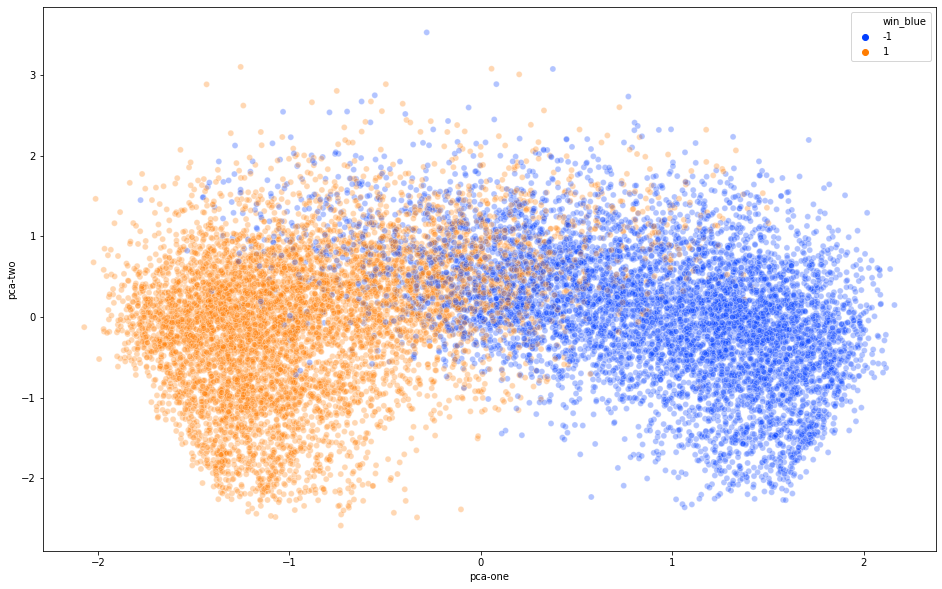

In [59]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="win_blue",
    data=output,
    legend="full",
    palette = 'bright',
    alpha=0.3)

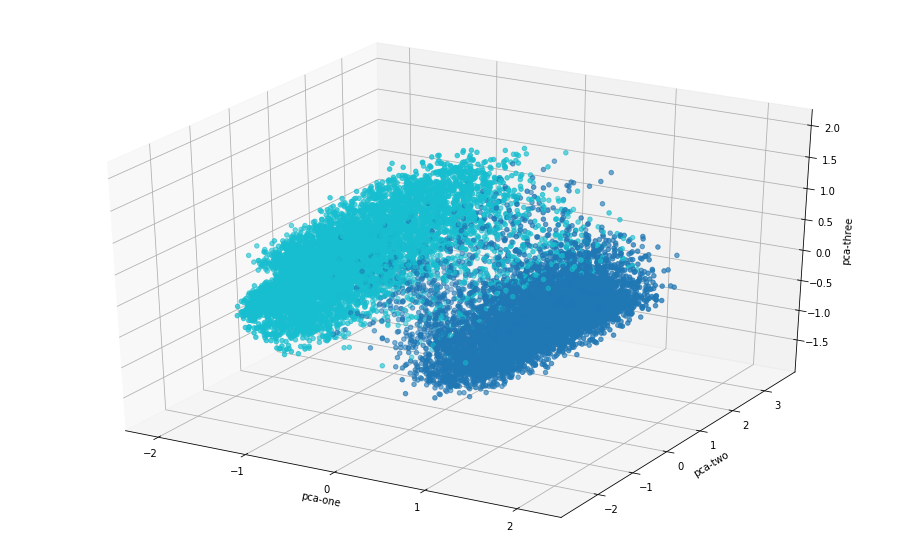

In [60]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=output["pca-one"], 
    ys=output["pca-two"], 
    zs=output["pca-three"], 
    c=output["win_blue"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [61]:
pca2 = PCA(n_components=3)
pca2.fit_transform(x_train.values)
loadings = pca2.components_.T * np.sqrt(pca2.explained_variance_)

loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2','PC3'], index=x.columns)

In [62]:
print(loading_matrix.sort_values(by='PC1')[:10])
print(loading_matrix.sort_values(by='PC1', ascending=False)[:10])

                                PC1       PC2       PC3
firstInhibitor_blue       -0.425143 -0.014786  0.191798
firstTower_blue           -0.359784 -0.017919 -0.198276
firstInhibitorKill_blue   -0.291222  0.019933  0.198928
firstRiftHerald_blue      -0.284330 -0.003303 -0.287649
firstTowerKill_blue       -0.278821 -0.016343 -0.199690
towerKills_blue           -0.262463  0.074820  0.078455
riftHeraldKills_blue      -0.252605  0.031343 -0.175524
firstBaron_blue           -0.207357  0.184366  0.182175
firstInhibitorAssist_blue -0.199686 -0.020479  0.103680
firstBlood_blue           -0.183341 -0.006357 -0.131291
                                  PC1       PC2       PC3
towerKills_red               0.257790  0.101296 -0.088286
riftHeraldKills_red          0.237545  0.027125  0.161805
turretKills_red              0.208764  0.074909 -0.066458
inhibitorKills_red           0.107861  0.032085 -0.050349
damageDealtToObjectives_red  0.106598  0.094217 -0.030400
dragonKills_red              0.10632

In [63]:
print(loading_matrix.sort_values(by='PC2')[:10])
print(loading_matrix.sort_values(by='PC2', ascending=False)[:10])

                                PC1       PC2       PC3
firstInhibitorAssist_blue -0.199686 -0.020479  0.103680
firstTower_blue           -0.359784 -0.017919 -0.198276
firstTowerKill_blue       -0.278821 -0.016343 -0.199690
firstInhibitor_blue       -0.425143 -0.014786  0.191798
firstDragon_blue          -0.155598 -0.009382  0.068875
firstTowerAssist_blue     -0.052607 -0.008587 -0.033399
firstBloodKill_blue       -0.160708 -0.007305 -0.124911
firstBlood_blue           -0.183341 -0.006357 -0.131291
perk2_blue                -0.001344 -0.003794 -0.000698
statPerk1_blue            -0.003431 -0.003762 -0.005001
                                       PC1       PC2       PC3
firstBaron_blue                  -0.207357  0.184366  0.182175
champLevel_blue                  -0.030567  0.143061  0.006452
champLevel_red                    0.031333  0.139344 -0.020820
gameDuration                     -0.004580  0.133740 -0.004202
goldEarned_red                    0.041198  0.128272 -0.018669
goldEa

In [65]:
print(loading_matrix.sort_values(by='PC3')[:10])
print(loading_matrix.sort_values(by='PC3', ascending=False)[:10])

                           PC1       PC2       PC3
firstRiftHerald_blue -0.284330 -0.003303 -0.287649
firstTowerKill_blue  -0.278821 -0.016343 -0.199690
firstTower_blue      -0.359784 -0.017919 -0.198276
riftHeraldKills_blue -0.252605  0.031343 -0.175524
firstBlood_blue      -0.183341 -0.006357 -0.131291
firstBloodKill_blue  -0.160708 -0.007305 -0.124911
towerKills_red        0.257790  0.101296 -0.088286
baronKills_red        0.074396  0.096062 -0.070040
turretKills_red       0.208764  0.074909 -0.066458
inhibitorKills_red    0.107861  0.032085 -0.050349
                                PC1       PC2       PC3
firstInhibitorKill_blue   -0.291222  0.019933  0.198928
firstInhibitor_blue       -0.425143 -0.014786  0.191798
firstBaron_blue           -0.207357  0.184366  0.182175
riftHeraldKills_red        0.237545  0.027125  0.161805
firstInhibitorAssist_blue -0.199686 -0.020479  0.103680
towerKills_blue           -0.262463  0.074820  0.078455
firstDragon_blue          -0.155598 -0.009382  

## Modeling

In [66]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(x_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(x_test)

/home/jaewon.jung.conda/anaconda3/envs/tf1.15/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Feature importance

In [67]:
coef_ser = pd.Series(clf.coef_.flatten(), index=x_train.columns)

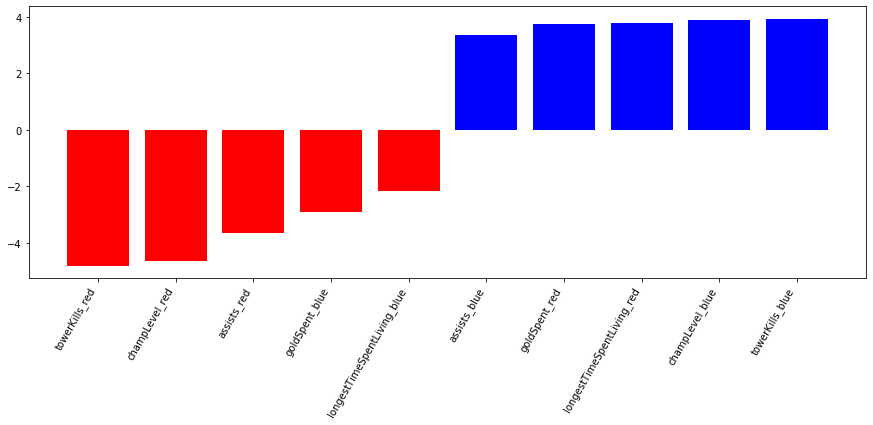

In [68]:
def plot_coefficients(classifier, feature_names, top_features=5):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 0 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

plot_coefficients(clf, x_train.columns)

In [69]:
print(coef_ser.sort_values(ascending=False)[:10])

towerKills_blue                        3.932132
champLevel_blue                        3.873773
longestTimeSpentLiving_red             3.785668
goldSpent_red                          3.744819
assists_blue                           3.350189
deaths_red                             2.121898
inhibitorKills_blue                    2.046732
neutralMinionsKilledEnemyJungle_red    1.648677
visionScore_red                        1.479266
goldEarned_blue                        1.469980
dtype: float64


In [70]:
print(coef_ser.sort_values(ascending=True)[:10])

towerKills_red                -4.814908
champLevel_red                -4.628058
assists_red                   -3.645723
goldSpent_blue                -2.908792
longestTimeSpentLiving_blue   -2.182988
goldEarned_red                -1.893719
deaths_blue                   -1.618910
inhibitorKills_red            -1.545783
timeCCingOthers_blue          -1.539337
magicDamageDealt_red          -1.350812
dtype: float64


# Evaluation

In [71]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9919719016557953


In [72]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.99      0.99      0.99      3005
           1       0.99      0.99      0.99      2974

    accuracy                           0.99      5979
   macro avg       0.99      0.99      0.99      5979
weighted avg       0.99      0.99      0.99      5979



In [73]:
mat = confusion_matrix(y_test, y_pred)
print(mat)

[[2982   23]
 [  25 2949]]
